In [1]:
import matplotlib
from matplotlib.animation import ArtistAnimation
import numpy as np
import metpy.plots as mpplots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from siphon.radarserver import RadarServer
rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

In [2]:
def raw_to_masked_float(var, data):
    if var._Unsigned:
        data = data & 255
        data = np.ma.array(data, mask=data==0)
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

def new_map(fig, lon, lat):
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m')) 
    ax.add_feature(cfeature.LAKES,alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    return ax

In [5]:
query = rs.query()
dt = datetime(2014, 11, 18, 0)
query.stations('KBUF').time_range(dt, dt + timedelta(hours=2))
cat = rs.get_catalog(query)
cat.datasets

['KBUF20141118_000222_V06.gz', 'KBUF20141118_000732_V06.gz', 'KBUF20141118_001241_V06.gz', 'KBUF20141118_001751_V06.gz', 'KBUF20141118_002259_V06.gz', 'KBUF20141118_002753_V06.gz', 'KBUF20141118_003246_V06.gz', 'KBUF20141118_003739_V06.gz', 'KBUF20141118_004232_V06.gz', 'KBUF20141118_004742_V06.gz', 'KBUF20141118_005234_V06.gz', 'KBUF20141118_005745_V06.gz', 'KBUF20141118_010254_V06.gz', 'KBUF20141118_010803_V06.gz', 'KBUF20141118_011313_V06.gz', 'KBUF20141118_011822_V06.gz', 'KBUF20141118_012331_V06.gz', 'KBUF20141118_012841_V06.gz', 'KBUF20141118_013350_V06.gz', 'KBUF20141118_013900_V06.gz', 'KBUF20141118_014409_V06.gz', 'KBUF20141118_014918_V06.gz', 'KBUF20141118_015428_V06.gz', 'KBUF20141118_015937_V06.gz']

Text(0.5, 1.0, 'Radar Imagery for Buffalo, NY         Valid 11/18/2014 at 00z to 11/19/2014 at 12z')

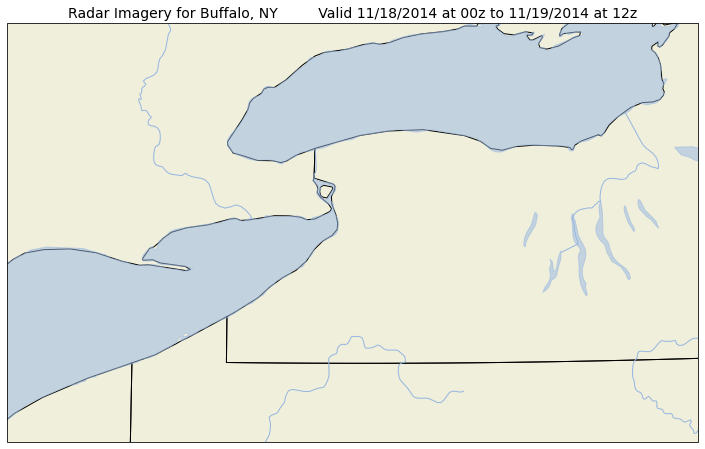

In [6]:
ds = cat.datasets[0]
data = ds.remote_access()

fig = plt.figure(figsize=(10, 7.5))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.set_extent([-81.5, -76, 44, 41.5])
ax.set_title('Radar Imagery for Buffalo, NY         Valid 11/18/2014 at 00z to 11/19/2014 at 12z', fontsize = 14) # Title of figure

In [7]:
cat.datasets[0].remote_access().variables

OrderedDict([('Reflectivity_HI',
              <siphon.cdmr.dataset.Variable at 0x7f720286e710>),
             ('timeR_HI', <siphon.cdmr.dataset.Variable at 0x7f720286e750>),
             ('elevationR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f720287a0d0>),
             ('azimuthR_HI', <siphon.cdmr.dataset.Variable at 0x7f720287afd0>),
             ('distanceR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f720287ac50>),
             ('numRadialsR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f720287ab90>),
             ('numGatesR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f7202873bd0>),
             ('Reflectivity',
              <siphon.cdmr.dataset.Variable at 0x7f7202873c10>),
             ('timeR', <siphon.cdmr.dataset.Variable at 0x7f7202873790>),
             ('elevationR', <siphon.cdmr.dataset.Variable at 0x7f72028736d0>),
             ('azimuthR', <siphon.cdmr.dataset.Variable at 0x7f7202877090>),
             ('distanceR', <siphon.cd

In [8]:
doplot='reflectivity'
#doplot='velocity'
if(doplot == 'reflectivity'):
    ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5) 
elif(doplot == 'velocity'):
    ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSVelocity', 0, 1)
meshes = []
for ds_name in cat.datasets:
    print(" Loading File ->", ds_name)
    data = cat.datasets[ds_name].remote_access()
    sweep = 0
    if(doplot == 'reflectivity'):
        rng = data.variables['distanceR_HI'][:]
        az = data.variables['azimuthR_HI'][sweep]
        ref_var = data.variables['Reflectivity_HI']
    elif(doplot == 'velocity'):
        rng = data.variables['distanceV_HI'][:]
        az = data.variables['azimuthV_HI'][sweep]
        ref_var = data.variables['RadialVelocity_HI']    
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.7, 0.02, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    meshes.append((mesh, text))

 Loading File -> KBUF20141118_000222_V06.gz
 Loading File -> KBUF20141118_000732_V06.gz
 Loading File -> KBUF20141118_001241_V06.gz
 Loading File -> KBUF20141118_001751_V06.gz
 Loading File -> KBUF20141118_002259_V06.gz
 Loading File -> KBUF20141118_002753_V06.gz
 Loading File -> KBUF20141118_003246_V06.gz
 Loading File -> KBUF20141118_003739_V06.gz
 Loading File -> KBUF20141118_004232_V06.gz
 Loading File -> KBUF20141118_004742_V06.gz
 Loading File -> KBUF20141118_005234_V06.gz
 Loading File -> KBUF20141118_005745_V06.gz
 Loading File -> KBUF20141118_010254_V06.gz
 Loading File -> KBUF20141118_010803_V06.gz
 Loading File -> KBUF20141118_011313_V06.gz
 Loading File -> KBUF20141118_011822_V06.gz
 Loading File -> KBUF20141118_012331_V06.gz
 Loading File -> KBUF20141118_012841_V06.gz
 Loading File -> KBUF20141118_013350_V06.gz
 Loading File -> KBUF20141118_013900_V06.gz
 Loading File -> KBUF20141118_014409_V06.gz
 Loading File -> KBUF20141118_014918_V06.gz
 Loading File -> KBUF20141118_01

In [9]:
matplotlib.rcParams['animation.html'] = 'html5'
print(" Loading Animation... ")
ArtistAnimation(fig, meshes, interval=100)

 Loading Animation... 
